In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

__Introduction & dataset overview__ :


ACCRE staff have hypothesized that the scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.

The goal is to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.

The Project makes use of three datasets:  

* fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".  
* slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).  
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:  
    * return code = 1
    * execution time > 15 seconds

**Phase 1: Explore the Data**  
Objectives:  
* Understand the purpose of each dataset.  
* Inspect column types, sizes, and example rows.  

In [2]:
# Read the fullsample dataset into jobs dataframe
jobs = pd.read_csv("../data/fullsample.csv")
jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [3]:
jobs.shape

(7395885, 12)

* jobs dataframe contains 7395885 rows and 12 columns

* The fullsample dataset contains job records, with one row per job.

* Each job gets a unique ID, contained in the **JOBID** column.

* Some jobs can be submitted as arrays of similar jobs. These are listed with an underscore in the JOBID, where the number after the   underscore indicates the tasknumber. For example. JOBID 31781951 was an array job with 10 parts.

In [4]:
jobs.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE'],
      dtype='object')

column | description
-------|---------
JOBID | The identification number of the job or job step. Array jobs are in the form ArrayJobID_ArrayTaskID
STATE | Job state or status (COMPLETED, CANCELLED, FAILED, TIMEOUT, PREEMPTED, etc.)
BEGIN | Beginning time for the job.
END | Ending time for the job.
REQMEM | Requested memory in megabytes. May be per-core (Mc) or per-node (Mn)
USEDMEM | Used memory in megabytes per-node
REQTIME | Requested time in d-hh:mm:ss or hh:mm:ss
USEDTIME | Used time in d-hh:mm:ss or hh:mm:ss
NODES | Number of servers used for this job
CPUS | Total number of CPU-cores allocated to the job
PARTITION | Identifies the partition on which the job ran.
EXITCODE | The exit code returned by the job script or salloc, typically as set by the exit() function. Following the colon is the signal that caused the process to terminate if it was terminated by a signal.

In [5]:
jobs.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   JOBID      7395885 non-null  object
 1   STATE      7395885 non-null  object
 2   BEGIN      7395885 non-null  object
 3   END        7395885 non-null  object
 4   REQMEM     7395885 non-null  object
 5   USEDMEM    7395885 non-null  object
 6   REQTIME    7395885 non-null  object
 7   USEDTIME   7395885 non-null  object
 8   NODES      7395885 non-null  int64 
 9   CPUS       7395885 non-null  int64 
 10  PARTITION  7395885 non-null  object
 11  EXITCODE   7395885 non-null  object
dtypes: int64(2), object(10)
memory usage: 677.1+ MB


* All the columns in the jobs dataframe contain non null values

In [6]:
(jobs['JOBID'].value_counts()>1).sum()

np.int64(0)

* Each row contains different JOBID

In [7]:
jobs['NODES'].value_counts().sort_values(ascending =False).reset_index()

,NODES,count
0,1,7385963
1,2,3525
2,3,2716
3,8,1447
4,4,860
...,...,...
70,133,1
71,28,1
72,26,1
73,65,1


Most jobs ran on 1,2,3 and 8 nodes.

In [8]:
jobs['PARTITION'].value_counts().sort_values(ascending =False)

PARTITION
production              7019578
nogpfs                   147229
pascal                   124453
sam                       64967
turing                    21424
maxwell                   11278
cgw-maizie                 4309
debug                      1616
cgw-platypus                379
cgw-dsi-gw                  228
cgw-capra1                  157
cgw-dougherty1              125
cgw-horus                    61
cgw-cqs1                     28
cgw-hanuman                  21
cgw-sideshowbob              14
cgw-vm-qa-flatearth1          9
cgw-tbi01                     8
cgw-rocksteady                1
Name: count, dtype: int64

Most jobs ran on the "production","nogpfs" and "pascal" partitions.

In [9]:
jobs.groupby(['STATE','EXITCODE'])['JOBID'].count().sort_values(ascending =False)

STATE                EXITCODE
COMPLETED            0:0         7375084
CANCELLED            0:0            5378
FAILED               1:0            2780
CANCELLED            0:15           1886
OUT_OF_MEMORY        0:125          1739
                                  ...   
CANCELLED by 649311  0:0               1
CANCELLED by 649321  0:15              1
CANCELLED by 651701  0:9               1
CANCELLED by 879160  1:0               1
CANCELLED by 161909  0:0               1
Name: JOBID, Length: 227, dtype: int64

We can see that most of the jobs are in "COMPLETED" with EXITCODE "0:0" then followed by CANCELLED and FAILED.

In [10]:
jobs[jobs['STATE']=='RUNNING']['END'].unique()

array(['Unknown'], dtype=object)

As we can see, if the job is in 'RUNNING' state the 'END' will be always in 'unknown'(date time)

In [11]:
#convert the BEGIN and END columns to date time format
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'],
                                           format = "%Y-%m-%dT%H:%M:%S", errors='coerce')

jobs['END'] = pd.to_datetime(jobs['END'],
                                           format = "%Y-%m-%dT%H:%M:%S", errors='coerce')



In [12]:
#convert the USEDTIME and REQTIME columns to timedelta format

jobs['USEDTIME'] = pd.to_timedelta(jobs['USEDTIME'].str.replace("-", " days ", 1))
jobs['REQTIME'] = pd.to_timedelta(jobs['REQTIME'].str.replace("-", " days ", 1))

In [13]:
 jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype          
---  ------     -----          
 0   JOBID      object         
 1   STATE      object         
 2   BEGIN      datetime64[ns] 
 3   END        datetime64[ns] 
 4   REQMEM     object         
 5   USEDMEM    object         
 6   REQTIME    timedelta64[ns]
 7   USEDTIME   timedelta64[ns]
 8   NODES      int64          
 9   CPUS       int64          
 10  PARTITION  object         
 11  EXITCODE   object         
dtypes: datetime64[ns](2), int64(2), object(6), timedelta64[ns](2)
memory usage: 677.1+ MB


In [14]:
jobs.sample(5)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
7282343,25342045_167,COMPLETED,2020-10-25 17:03:32,2020-10-25 17:04:02,2048Mn,0,0 days 04:00:00,0 days 00:00:30,1,1,production,0:0
6613273,26088375,COMPLETED,2020-11-29 15:56:02,2020-11-29 15:56:09,6144Mn,0,1 days 00:00:00,0 days 00:00:07,1,1,pascal,0:0
5500204,26790233_5,COMPLETED,2021-01-14 22:22:06,2021-01-15 00:41:10,65536Mn,153.65M,0 days 12:00:00,0 days 02:19:04,1,4,production,0:0
5738174,27007562_4902,COMPLETED,2021-01-29 17:52:05,2021-01-29 18:14:42,2048Mn,508.53M,0 days 01:00:00,0 days 00:22:37,1,1,production,0:0
4885057,27147539_9503,COMPLETED,2021-02-03 19:52:04,2021-02-03 19:53:40,2048Mn,936.12M,0 days 00:15:00,0 days 00:01:36,1,1,production,0:0


The __slurm_wrapper_ce5.log__ and __slurm_wrapper_ce6.log__ files contain logs of jobs submitted from the Open Science Grid.

In [15]:
# Read the slurm_wrapper_ce5.log dataset into jobs ce5

ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce5.head()

,0,1,2,3,4,5
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [16]:
ce5.shape

(4770893, 6)

* ce5 dataframe contains 4770893 rows and 6 columns

In [17]:
ce5.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770893 entries, 0 to 4770892
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       4770893 non-null  object
 1   1       4770893 non-null  object
 2   2       4770893 non-null  object
 3   3       4770893 non-null  object
 4   4       4770893 non-null  object
 5   5       4770893 non-null  object
dtypes: object(6)
memory usage: 218.4+ MB


In [18]:
# Rename the column names of ce5 dataframe

new_column_names = ['date', 'user', 'retry' , 'time', 'return_code', 'command']
ce5.columns = new_column_names
ce5.head()

,date,user,retry,time,return_code,command
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [19]:
# Read the slurm_wrapper_ce6.log dataset into jobs ce6

ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce6.head()

,0,1,2,3,4,5
0,2020-10-16 10:37:44.163454,user 9202,retry 0,time 0.08495402336120605,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
1,2020-10-16 10:37:44.206654,user 9202,retry 0,time 0.08943057060241699,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
2,2020-10-16 10:37:44.218760,user 9202,retry 0,time 0.05928945541381836,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
3,2020-10-16 10:37:44.256403,user 9202,retry 0,time 0.038695573806762695,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
4,2020-10-16 10:37:44.611603,user 9202,retry 0,time 0.03343677520751953,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."


In [20]:
ce6.shape

(4776520, 6)

ce6 dataframe contains 4776520 rows and 6 columns

In [21]:
ce6.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776520 entries, 0 to 4776519
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       4776520 non-null  object
 1   1       4776520 non-null  object
 2   2       4776520 non-null  object
 3   3       4776520 non-null  object
 4   4       4776520 non-null  object
 5   5       4776520 non-null  object
dtypes: object(6)
memory usage: 218.7+ MB


In [22]:
#Rename the column names

new_column_names = ['date', 'user', 'retry' , 'time', 'return_code', 'command']
ce6.columns = new_column_names
ce6.head()

,date,user,retry,time,return_code,command
0,2020-10-16 10:37:44.163454,user 9202,retry 0,time 0.08495402336120605,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
1,2020-10-16 10:37:44.206654,user 9202,retry 0,time 0.08943057060241699,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
2,2020-10-16 10:37:44.218760,user 9202,retry 0,time 0.05928945541381836,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
3,2020-10-16 10:37:44.256403,user 9202,retry 0,time 0.038695573806762695,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
4,2020-10-16 10:37:44.611603,user 9202,retry 0,time 0.03343677520751953,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."


**Phase 2: Clean and Transform the Data**  
Objectives:  
* Extract job completions from fullsample.csv.  
* Parse CE5 and CE6 logs to identify unresponsive events.  
* Create analysis-ready features (time windows, completion counts, unresponsiveness indicators).  
* Optionally include other features (currently running jobs or resource usage, time-of-day).  


In [23]:
#Extract job completions from fullsample.csv

completed_jobs = jobs[(jobs['STATE'] == 'COMPLETED') &  (jobs['EXITCODE'] == '0:0')]
print(f' There are {completed_jobs.shape[0]} COMPLETED jobs in the dataset')

 There are 7375084 COMPLETED jobs in the dataset


In [69]:
# Parse CE5 and CE6 logs to identify unresponsive events.

#concat two dfs to stack the rows vertically , when both the data frames have same columns

concat_logs = pd.concat([ce5,ce6], ignore_index = True)

concat_logs.shape

(9547413, 6)

In [70]:
concat_logs.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   date         9547413 non-null  object
 1   user         9547413 non-null  object
 2   retry        9547413 non-null  object
 3   time         9547413 non-null  object
 4   return_code  9547413 non-null  object
 5   command      9547413 non-null  object
dtypes: object(6)
memory usage: 437.0+ MB


In [71]:
#convert the date column datatype  to date time format and truncate the milliseconds

concat_logs['date'] = pd.to_datetime(concat_logs['date'],errors='coerce').dt.floor('s')
concat_logs['time'] = concat_logs['time'].str.replace('time', "", regex = False).astype(float)

In [73]:
concat_logs.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         9547398 non-null  datetime64[ns]
 1   user         9547413 non-null  object        
 2   retry        9547413 non-null  object        
 3   time         9547413 non-null  float64       
 4   return_code  9547413 non-null  object        
 5   command      9547413 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 437.0+ MB


Parse CE5 and CE6 logs to filter just the events where the user (user 9204) sent an sbatch command (i.e. the command starts with '/usr/bin/sbatch') to the scheduler.

In [30]:
pd.set_option('display.max_colwidth', None) #To display the full column(here looking for command column) values with out cut off

sbatch_events = concat_logs[(concat_logs['user'] == 'user 9204') & (concat_logs['command'].str.contains(r"'/usr/bin/(sbatch)'"))]

/var/folders/n1/v3s1h2t95hb_nmn96mg49sbm0000gn/T/ipykernel_50575/3450373780.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sbatch_events = concat_logs[(concat_logs['user'] == 'user 9204') & (concat_logs['command'].str.contains(r"'/usr/bin/(sbatch)'"))]


Now add the indicator variable for  responsive (i.e. the returncode is zero and the time is less than 15) or unresponsive (i.e. the returncode is non-zero and the time is greater than 15). We will use an indicator of 1 to indicate the scheduler was unresponsive, and 0 to indicate the scheduler was responsive, since we are interested in predicting when the scheduler will be unresponsive.

In [31]:
sbatch_events['unresponsive'] = ((sbatch_events['return_code'] == 'returncode 1') & (sbatch_events['time'] > 15)).astype(int)

/var/folders/n1/v3s1h2t95hb_nmn96mg49sbm0000gn/T/ipykernel_50575/3262054003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbatch_events['unresponsive'] = ((sbatch_events['return_code'] == 'returncode 1') & (sbatch_events['time'] > 15)).astype(int)


In [32]:
(sbatch_events['unresponsive']==1).sum()

np.int64(3296)

we have total 3296 unresponsive events

In [33]:
completed_jobs.head(2)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30 days,30 days 00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30 days,30 days 00:00:14,1,32,cgw-tbi01,0:0


In [34]:
# Import sbatch_events files to csv 
sbatch_events.to_csv('sbatch_events.csv')
sbatch_events.head()

,date,user,retry,time,return_code,command,unresponsive
136,2020-10-16 08:34:42,user 9204,retry 0,5.240251,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5590dbe24f10.2098696/bl_VFUUpl']",0
478,2020-10-16 08:53:15,user 9204,retry 0,0.142444,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5590d7f1d1d0.2098696/bl_rNSZcf']",0
670,2020-10-16 09:04:56,user 9204,retry 0,0.066345,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5590d8ce0c20.2098696/bl_3G8o5r']",0
826,2020-10-16 09:24:26,user 9204,retry 0,0.072883,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5590db72ae60.2098696/bl_p0Hwgv']",0
923,2020-10-16 09:34:24,user 9204,retry 0,0.076409,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x556923592de0.1343760/bl_x0Wm87']",0


In [35]:
sbatch_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61247 entries, 136 to 9547412
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          61247 non-null  datetime64[ns]
 1   user          61247 non-null  object        
 2   retry         61247 non-null  object        
 3   time          61247 non-null  float64       
 4   return_code   61247 non-null  object        
 5   command       61247 non-null  object        
 6   unresponsive  61247 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 3.7+ MB


In [36]:
completed_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7375084 entries, 1 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype          
---  ------     -----          
 0   JOBID      object         
 1   STATE      object         
 2   BEGIN      datetime64[ns] 
 3   END        datetime64[ns] 
 4   REQMEM     object         
 5   USEDMEM    object         
 6   REQTIME    timedelta64[ns]
 7   USEDTIME   timedelta64[ns]
 8   NODES      int64          
 9   CPUS       int64          
 10  PARTITION  object         
 11  EXITCODE   object         
dtypes: datetime64[ns](2), int64(2), object(6), timedelta64[ns](2)
memory usage: 731.5+ MB


__TIME WINDOWS__

In [38]:
#Sort the values by END Date
completed_jobs = completed_jobs.sort_values(by = 'END')

# Calculate number of completed jobs in different time intervals prior to each job's end time
completed_jobs['completed_rolling_5min']= completed_jobs.rolling(window ='5min', on='END')['JOBID'].count().astype(int)
completed_jobs['completed_rolling_10min'] = completed_jobs.rolling(window ='10min', on='END')['JOBID'].count().astype(int)
completed_jobs['completed_rolling_15min'] = completed_jobs.rolling(window ='15min', on='END')['JOBID'].count().astype(int)
completed_jobs['completed_rolling_30min'] = completed_jobs.rolling(window ='30min', on='END')['JOBID'].count().astype(int)
completed_jobs['completed_rolling_45min'] = completed_jobs.rolling(window ='45min', on='END')['JOBID'].count().astype(int)
completed_jobs['completed_rolling_1h'] = completed_jobs.rolling(window ='1h', on='END')['JOBID'].count().astype(int)
completed_jobs.tail()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,completed_rolling_5min,completed_rolling_10min,completed_rolling_15min,completed_rolling_30min,completed_rolling_45min,completed_rolling_1h
927386,32923987,COMPLETED,2021-10-07 20:09:26,2021-10-07 20:11:21,2000Mn,0.09M,2 days,0 days 00:01:55,1,1,sam,0:0,1,2,3,4,6,9
927387,32923988,COMPLETED,2021-10-07 20:15:05,2021-10-07 20:17:24,2000Mn,0.09M,2 days,0 days 00:02:19,1,1,sam,0:0,1,2,3,5,7,9
927388,32923989,COMPLETED,2021-10-07 20:24:26,2021-10-07 20:26:01,2000Mn,393.07M,2 days,0 days 00:01:35,1,1,sam,0:0,1,2,3,5,7,8
1491977,32923996,COMPLETED,2021-10-07 20:31:08,2021-10-07 20:32:45,2000Mn,0.09M,2 days,0 days 00:01:37,1,1,sam,0:0,1,2,2,5,6,9
1491978,32923997,COMPLETED,2021-10-07 20:39:26,2021-10-07 20:41:11,2000Mn,0.09M,2 days,0 days 00:01:45,1,1,sam,0:0,1,2,2,5,7,9


In [39]:
completed_jobs[['completed_rolling_5min','completed_rolling_10min','completed_rolling_15min','completed_rolling_30min','completed_rolling_45min','completed_rolling_1h']].sum()

completed_rolling_5min      2063388677
completed_rolling_10min     3766379882
completed_rolling_15min     5339980214
completed_rolling_30min     9580759729
completed_rolling_45min    13455942899
completed_rolling_1h       17085121694
dtype: int64

__Merging sbatch events logs with completed jobs using merge_asof() and matched each sbatch commands near by job comletions__

Merge the slurm logs and ACCRE job completion data. We'll associate each test sbatch command with the ACCRE job that was completed most recently. 

In [75]:
# Sort by command date and end job values
sbatch_events = sbatch_events.sort_values(by ='date')
completed_jobs = completed_jobs.sort_values(by = 'END')

# Use merge_asof to join sbatch commands with the closest job completions
jobs_data = pd.merge_asof(left = sbatch_events,right = completed_jobs,left_on= 'date', right_on ='END' )
print(f' After merging unresponsive jobs with completed jobs got {jobs_data.shape[0]} rows and {jobs_data.shape[1]} columns')

 After merging unresponsive jobs with completed jobs got 61247 rows and 25 columns


In [76]:
jobs_data.head(2)

,date,user,retry,time,return_code,command,unresponsive,JOBID,STATE,BEGIN,...,NODES,CPUS,PARTITION,EXITCODE,completed_rolling_5min,completed_rolling_10min,completed_rolling_15min,completed_rolling_30min,completed_rolling_45min,completed_rolling_1h
0,2020-10-16 08:34:42,user 9204,retry 0,5.240251,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5590dbe24f10.2098696/bl_VFUUpl']",0,24962765_302,COMPLETED,2020-10-16 03:22:16,...,1,2,production,0:0,41,76,105,157,396,581
1,2020-10-16 08:53:15,user 9204,retry 0,0.142444,returncode 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5590d7f1d1d0.2098696/bl_rNSZcf']",0,24949525_16,COMPLETED,2020-10-16 08:53:07,...,1,1,production,0:0,72,126,181,307,361,436


**Phase 3: Analyze and Visualize**  
Objectives:  
* Explore the relationship between job completions and unresponsiveness.  
* Create visualizations and basic summary statistics.  

* Summary statistics

In [77]:
Avg_number_completed_jobs = completed_jobs[['completed_rolling_5min','completed_rolling_10min','completed_rolling_15min','completed_rolling_30min','completed_rolling_45min','completed_rolling_1h']].mean()
print(f' Average number of completed jobs with sbatch comand in the different time intervels \n{Avg_number_completed_jobs} ')

 Average number of completed jobs with sbatch comand in the different time intervels 
completed_rolling_5min      279.778329
completed_rolling_10min     510.689761
completed_rolling_15min     724.056867
completed_rolling_30min    1299.071269
completed_rolling_45min    1824.513849
completed_rolling_1h       2316.600285
dtype: float64 


__Visualizations__

Plot the unresponsive and responsive jobs counts based on the Rolling count time windows

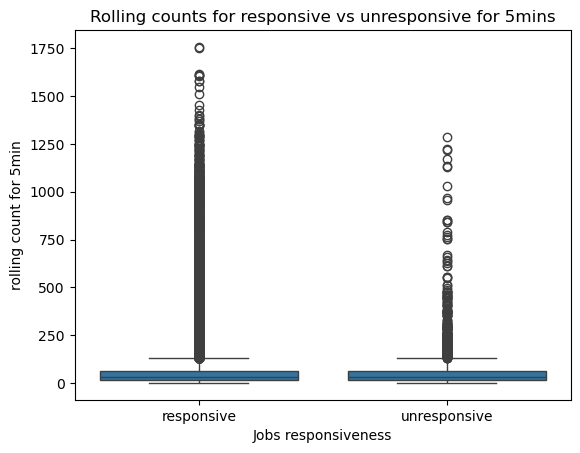

In [79]:
#boxplot by using seaborn
sns.boxplot(data = jobs_data, x= 'unresponsive', y = 'completed_rolling_5min')
plt.xlabel('Jobs responsiveness')
plt.ylabel('rolling count for 5min')
plt.title('Rolling counts for responsive vs unresponsive for 5mins')
plt.xticks(ticks=range(len(jobs_data['unresponsive'].unique())),labels=['responsive','unresponsive'])
plt.show();

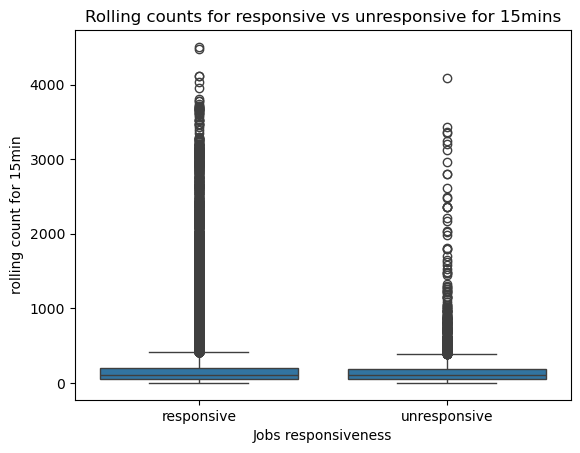

In [80]:
sns.boxplot(data = jobs_data, x= 'unresponsive', y = 'completed_rolling_15min')
plt.xlabel('Jobs responsiveness')
plt.ylabel('rolling count for 15min')
plt.title('Rolling counts for responsive vs unresponsive for 15mins')
plt.xticks(ticks=range(len(jobs_data['unresponsive'].unique())),labels=['responsive','unresponsive'])
plt.show();

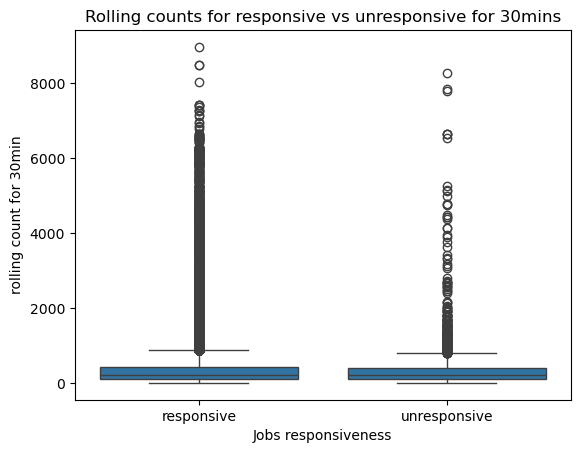

In [81]:
sns.boxplot(data = jobs_data, x= 'unresponsive', y = 'completed_rolling_30min')
plt.xlabel('Jobs responsiveness')
plt.ylabel('rolling count for 30min')
plt.title('Rolling counts for responsive vs unresponsive for 30mins')
plt.xticks(ticks=range(len(jobs_data['unresponsive'].unique())),labels=['responsive','unresponsive'])
plt.show();

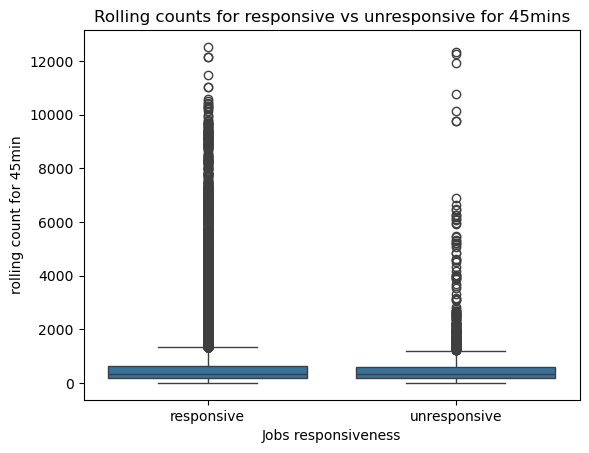

In [82]:
sns.boxplot(data = jobs_data, x= 'unresponsive', y = 'completed_rolling_45min')
plt.xlabel('Jobs responsiveness')
plt.ylabel('rolling count for 45min')
plt.title('Rolling counts for responsive vs unresponsive for 45mins')
plt.xticks(ticks=range(len(jobs_data['unresponsive'].unique())),labels=['responsive','unresponsive'])
plt.show();

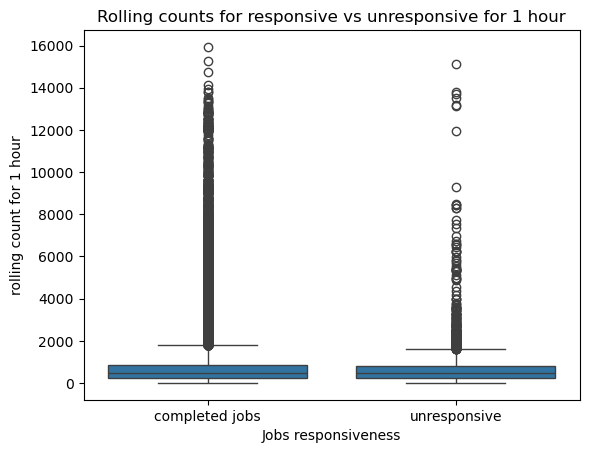

In [83]:
sns.boxplot(data = jobs_data, x= 'unresponsive', y = 'completed_rolling_1h')
plt.xlabel('Jobs responsiveness')
plt.ylabel('rolling count for 1 hour')
plt.title('Rolling counts for responsive vs unresponsive for 1 hour')
plt.xticks(ticks=range(len(jobs_data['unresponsive'].unique())),labels=['completed jobs','unresponsive'])
plt.show()

The distribution of job completions are very similar for the each time interval . There is a strong right skew with many outliers.

__Statistical Modeling__

In [49]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

Checking the relationship between unresponsiveness and jobs completion using logistic regression model.
Use the different time windows and compare modals.

In [50]:
# 5mins time window
logreg_jobs_5min = smf.logit("unresponsive ~ completed_rolling_5min",
                          data = jobs_data).fit()


Optimization terminated successfully.
         Current function value: 0.209525
         Iterations 7


In [51]:
logreg_jobs_5min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           unresponsive   No. Observations:                61247
Model:                          Logit   Df Residuals:                    61245
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               0.0003473
Time:                        18:12:11   Log-Likelihood:                -12833.
converged:                       True   LL-Null:                       -12837.
Covariance Type:            nonrobust   LLR p-value:                  0.002824
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.8362      0.021   -137.366      0.000      -2.877      -2.796
completed_rolling_5min    -0.0005      0.000     -2.856      0.004      -0.001      -0.000
==========================================================================================
"""

* The coefficient for number of completed ACCRE jobs in the lat 5 mins is -0.0005 with a p-value 0.004 which is less than alpha=0.05.
so it is statistically significant.

* Each additional completed job in the last 5 minutes reduces the log-odds of unresponsiveness by 0.0005

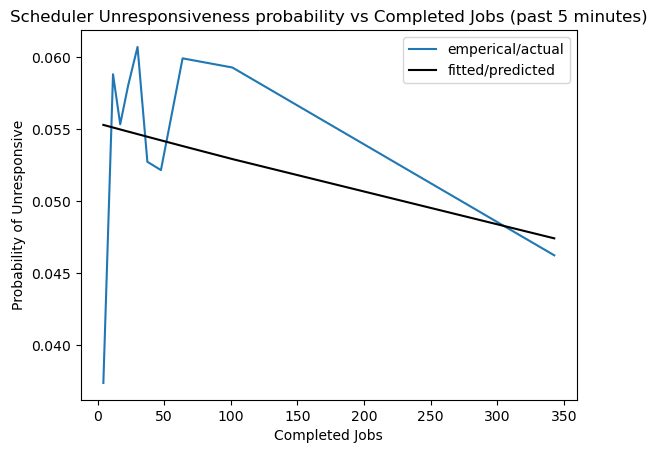

In [52]:
#Make the summary table
resp_summary = (
    jobs_data
    .assign(group = pd.qcut(jobs_data['completed_rolling_5min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['completed_rolling_5min', 'unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'unresponsive': 'eprob'})
)

#Adding the fitted/predicted probability
resp_summary['fit_prob'] = logreg_jobs_5min.predict(resp_summary[['completed_rolling_5min']])

ax = resp_summary.plot(x = 'completed_rolling_5min', y = 'eprob', label = 'emperical/actual')
resp_summary.plot(x = 'completed_rolling_5min', y = 'fit_prob',label = 'fitted/predicted',
                color = 'black',
                ax = ax);
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of Unresponsive")
plt.title("Scheduler Unresponsiveness probability vs Completed Jobs (past 5 minutes)");


The unresponsiveness of jobs is 5-6% for the lower to mid loads.
The model shows the probability of being unresponsive decreses as the completion of jobs increases for the past 5 mins.

15 mins window

In [53]:
logreg_jobs_15min = smf.logit("unresponsive ~ completed_rolling_15min",
                          data = jobs_data).fit()

Optimization terminated successfully.
         Current function value: 0.209521
         Iterations 7


In [54]:
logreg_jobs_15min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           unresponsive   No. Observations:                61247
Model:                          Logit   Df Residuals:                    61245
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               0.0003689
Time:                        18:12:15   Log-Likelihood:                -12833.
converged:                       True   LL-Null:                       -12837.
Covariance Type:            nonrobust   LLR p-value:                  0.002088
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.8320      0.021   -133.452      0.000      -2.874      -2.790
completed_rolling_15min    -0.0002   6.26e-05     -2.945      0.003      -0.000   -6.17e-05
===========================================================================================
"""

The coefficient for number of completed ACCRE jobs in the lat 15 mins is -0.0002 with a p-value 0.003 which is less than alpha=0.05.
so it is statistically significant.

* Each additional completed job in the last 15 minutes reduces the log-odds of unresponsiveness by 0.0002

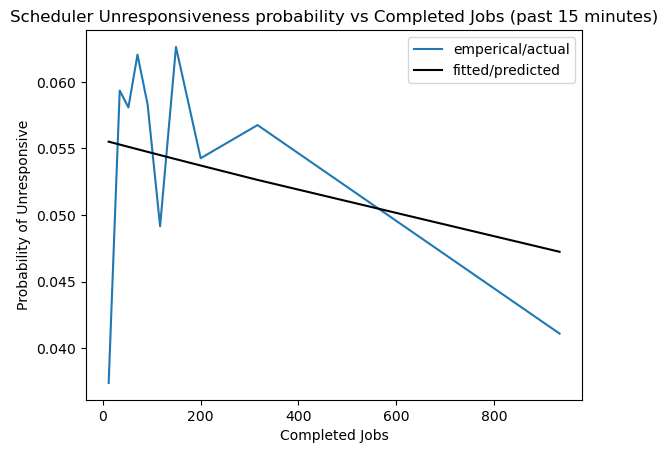

In [55]:
#Make the summary table
resp_summary = (
    jobs_data
    .assign(group = pd.qcut(jobs_data['completed_rolling_15min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['completed_rolling_15min', 'unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'unresponsive': 'eprob'})
)

#Adding the fitted/predicted probability
resp_summary['fit_prob'] = logreg_jobs_15min.predict(resp_summary[['completed_rolling_15min']])

ax = resp_summary.plot(x = 'completed_rolling_15min', y = 'eprob', label = 'emperical/actual')
resp_summary.plot(x = 'completed_rolling_15min', y = 'fit_prob',label = 'fitted/predicted',
                color = 'black',
                ax = ax);
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of Unresponsive")
plt.title("Scheduler Unresponsiveness probability vs Completed Jobs (past 15 minutes)");

30mins Interval

In [56]:
logreg_jobs_30min = smf.logit("unresponsive ~ completed_rolling_30min",
                          data = jobs_data).fit()

Optimization terminated successfully.
         Current function value: 0.209520
         Iterations 7


In [57]:
logreg_jobs_30min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           unresponsive   No. Observations:                61247
Model:                          Logit   Df Residuals:                    61245
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               0.0003721
Time:                        18:12:20   Log-Likelihood:                -12832.
converged:                       True   LL-Null:                       -12837.
Covariance Type:            nonrobust   LLR p-value:                  0.001995
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.8293      0.022   -130.483      0.000      -2.872      -2.787
completed_rolling_30min -9.927e-05   3.36e-05     -2.958      0.003      -0.000   -3.35e-05
===========================================================================================
"""

* The coefficient for number of completed ACCRE jobs in the lat 30 mins is -9.927e-05 with a p-value 	0.003 which is less than alpha=0.05. so it is statistically significant.

* Each additional completed job in the last 30 minutes reduces the log-odds of unresponsiveness by 9.927e-05

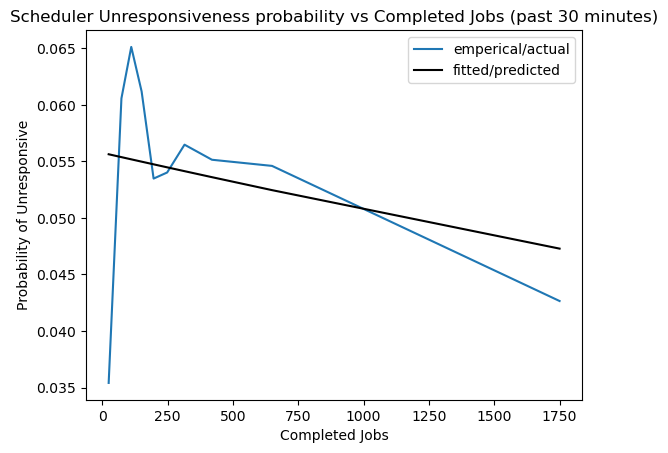

In [58]:
#Make the summary table
resp_summary = (
    jobs_data
    .assign(group = pd.qcut(jobs_data['completed_rolling_30min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['completed_rolling_30min', 'unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'unresponsive': 'eprob'})
)

#Adding the fitted/predicted probability
resp_summary['fit_prob'] = logreg_jobs_30min.predict(resp_summary[['completed_rolling_30min']])

ax = resp_summary.plot(x = 'completed_rolling_30min', y = 'eprob', label = 'emperical/actual')
resp_summary.plot(x = 'completed_rolling_30min', y = 'fit_prob',label = 'fitted/predicted',
                color = 'black',
                ax = ax);
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of Unresponsive")
plt.title("Scheduler Unresponsiveness probability vs Completed Jobs (past 30 minutes)");

45mins Window

In [59]:
logreg_jobs_45min = smf.logit("unresponsive ~ completed_rolling_45min",
                          data = jobs_data).fit()

Optimization terminated successfully.
         Current function value: 0.209502
         Iterations 7


In [60]:
logreg_jobs_45min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           unresponsive   No. Observations:                61247
Model:                          Logit   Df Residuals:                    61245
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               0.0004574
Time:                        18:12:27   Log-Likelihood:                -12831.
converged:                       True   LL-Null:                       -12837.
Covariance Type:            nonrobust   LLR p-value:                 0.0006108
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.8232      0.022   -128.117      0.000      -2.866      -2.780
completed_rolling_45min -7.729e-05   2.37e-05     -3.266      0.001      -0.000   -3.09e-05
===========================================================================================
"""

* The coefficient for number of completed ACCRE jobs in the lat 5 mins is -7.729e-05 with a p-value 0.001 which is less than alpha=0.05.
so it is statistically significant.

* Each additional completed job in the last 45 minutes reduces the log-odds of unresponsiveness by 7.729e-05

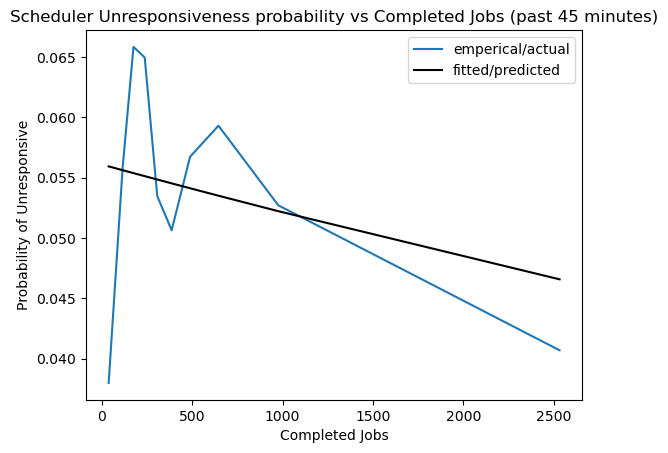

In [61]:
#Make the summary table
resp_summary = (
    jobs_data
    .assign(group = pd.qcut(jobs_data['completed_rolling_45min'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['completed_rolling_45min', 'unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'unresponsive': 'eprob'})
)

#Adding the fitted/predicted probability
resp_summary['fit_prob'] = logreg_jobs_45min.predict(resp_summary[['completed_rolling_45min']])

ax = resp_summary.plot(x = 'completed_rolling_45min', y = 'eprob', label = 'emperical/actual')
resp_summary.plot(x = 'completed_rolling_45min', y = 'fit_prob',label = 'fitted/predicted',
                color = 'black',
                ax = ax);
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of Unresponsive")
plt.title("Scheduler Unresponsiveness probability vs Completed Jobs (past 45 minutes)");

1hr window

In [62]:
logreg_jobs_1hr = smf.logit("unresponsive ~ completed_rolling_1h",
                          data = jobs_data).fit()

Optimization terminated successfully.
         Current function value: 0.209509
         Iterations 7


In [63]:
logreg_jobs_1hr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           unresponsive   No. Observations:                61247
Model:                          Logit   Df Residuals:                    61245
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:               0.0004248
Time:                        18:12:30   Log-Likelihood:                -12832.
converged:                       True   LL-Null:                       -12837.
Covariance Type:            nonrobust   LLR p-value:                 0.0009585
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.8234      0.022   -126.690      0.000      -2.867      -2.780
completed_rolling_1h -5.759e-05   1.82e-05     -3.156      0.002   -9.34e-05   -2.18e-05
========================================================================================
"""

* The coefficient for number of completed ACCRE jobs in the last 1 hour is -5.759e-05 with a p-value 0.002 which is less than alpha=0.05.
so it is statistically significant.

* Each additional completed job in the last 1 hour reduces the log-odds of unresponsiveness by 5.759e-05

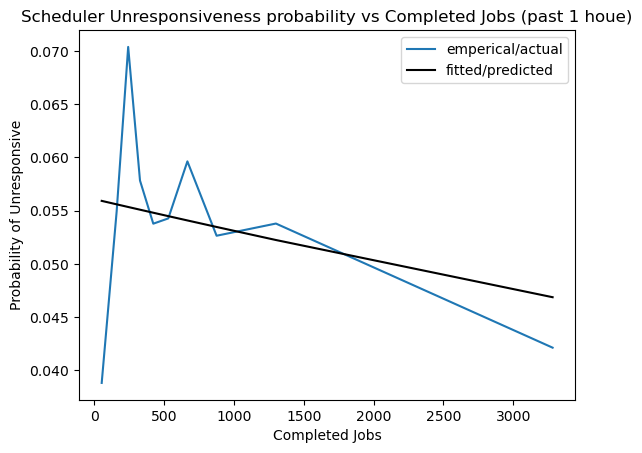

In [64]:
#Make the summary table
resp_summary = (
    jobs_data
    .assign(group = pd.qcut(jobs_data['completed_rolling_1h'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['completed_rolling_1h', 'unresponsive']]
    .mean()
    .reset_index()
    .rename(columns = {'unresponsive': 'eprob'})
)

#Adding the fitted/predicted probability
resp_summary['fit_prob'] = logreg_jobs_1hr.predict(resp_summary[['completed_rolling_1h']])

ax = resp_summary.plot(x = 'completed_rolling_1h', y = 'eprob', label = 'emperical/actual')
resp_summary.plot(x = 'completed_rolling_1h', y = 'fit_prob',label = 'fitted/predicted',
                color = 'black',
                ax = ax);
plt.xlabel("Completed Jobs")
plt.ylabel("Probability of Unresponsive")
plt.title("Scheduler Unresponsiveness probability vs Completed Jobs (past 1 houe)");

The logistical regression captures downward trend but more smoothly.
All the models shows the probability of being unresponsive decreases as the completion of jobs increases .

Create a relationship between unresponsiveness and day of the week using regression model.

In [65]:
#Extracting day name from the date
jobs_data['day_name'] = jobs_data['date'].dt.day_name()

In [66]:
res_logreg = smf.logit("unresponsive ~ day_name",
                          data = jobs_data).fit()

Optimization terminated successfully.
         Current function value: 0.207980
         Iterations 7


In [67]:
res_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           unresponsive   No. Observations:                61247
Model:                          Logit   Df Residuals:                    61240
Method:                           MLE   Df Model:                            6
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                0.007721
Time:                        18:12:33   Log-Likelihood:                -12738.
converged:                       True   LL-Null:                       -12837.
Covariance Type:            nonrobust   LLR p-value:                 4.494e-40
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.4936      0.040    -62.357      0.000      -2.572      -2.415
day_name[T.Monday]       -0.2181      0.060     -3.663      0.000      -0.335      -0.101
day_name[T.Saturday]     -0.5207      0.065     -8.063      0.000      -0.647      -0.394
day_name[T.Sunday]       -0.8025      0.070    -11.498      0.000      -0.939      -0.666
day_name[T.Thursday]     -0.5283      0.065     -8.163      0.000      -0.655      -0.401
day_name[T.Tuesday]      -0.5415      0.065     -8.277      0.000      -0.670      -0.413
day_name[T.Wednesday]    -0.2063      0.059     -3.467      0.001      -0.323      -0.090
=========================================================================================
"""

* After applying the Bonferroni correction use the alpha value 0.05/6 = 0.0083
* After using Bonferroni correction the models coefficients are statistically significant (all of them are <0.0083)

__5. Interpretation & conclusion__

The data does not supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness. Our logical regression models shows that the when completion of jobs increase the probability of scheduler unresponsiveness decreases.
Although the effect size is small the logistic regression indicates that increased job completion activity is associated with a statistically significant decrease in the odds of scheduler unresponsiveness, contradicting the hypothesis that completion bursts contribute to unresponsiveness.
